## Code required to create Figure 4
Entire notebook takes ~30 minutes to run on Intel i7-10750 using > 10GB RAM

In [1]:
import collections
import datetime
import glob
import re
import os
import pandas as pd
import numpy as np
import xarray as xr
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

sns.set_context('paper')

# Functions to load CMIP6 runs

In [48]:
def make_combined_df_from_data_paths(data_paths, ignored_data_paths, date_format="\d{2}:\d{2}:\d{2}", data_name=None):
    first_ind = 0 ## FIX: what if first value is not enough days (I am leaving for now, but could use recursion)
    df = pd.read_csv(data_paths[first_ind])
    df = remove_unwanted_columns(df)
    wrote_data_name = False
    if not data_name:
        data_name = os.path.split(data_paths[first_ind])[-1].split("_")[2] + "_" + os.path.split(data_paths[first_ind])[-1].split("_")[4]
        wrote_data_name = True
    df.columns = ["time", data_name]
    # remove time from date
    df['time'] = df['time'].apply(lambda x: re.sub(date_format, "", x).strip())
    for f in data_paths[first_ind+1:]:
        if f in ignored_data_paths:
            # print(f)
            continue
        current = pd.read_csv(f, header=0)
        current = remove_unwanted_columns(current)
        if wrote_data_name:
            current_data_name = os.path.split(f)[-1].split("_")[2] + "_" + os.path.split(f)[-1].split("_")[4]
        else:
            current_data_name = data_name
        current.columns = ["time", current_data_name] # Note: makes the assumption that time and jet lat is this way around (check because would fail otherwise)
        # remove time from date
        current['time'] = current['time'].apply(lambda x: re.sub(date_format, "", x).strip())
        df = df.merge(current, how='outer', on='time')
    df = df.set_index('time')
    df = df.sort_index()
    return df


def make_combined_df_from_data_paths_for_bracegirdle(data_paths, ignored_data_paths, data_name=None):
    first_ind = 0 ## FIX: what if first value is not enough days (I am leaving for now, but could use recursion)
    df = pd.read_csv(data_paths[first_ind])
    df = remove_unwanted_columns(df)
    wrote_data_name = False
    if not data_name:
        data_name = os.path.split(data_paths[first_ind])[-1].split("_")[2] + "_" + os.path.split(data_paths[first_ind])[-1].split("_")[4]
        wrote_data_name = True
    df.columns = ["year", data_name] # Note: makes the assumption that time and jet lat is this way around (check because would fail otherwise)
    # remove time from date
    for f in data_paths[first_ind+1:]:
        if f in ignored_data_paths:
            continue
        current = pd.read_csv(f, header=0)
        current = remove_unwanted_columns(current)
        if wrote_data_name:
            current_data_name = os.path.split(f)[-1].split("_")[2] + "_" + os.path.split(f)[-1].split("_")[4]
        else:
            current_data_name = data_name
        current.columns = ["year", current_data_name] # Note: makes the assumption that time and jet lat is this way around (check because would fail otherwise)
        # remove time from date
        df = df.merge(current, how='outer', on='year')
    df = df.set_index('year')
    df = df.sort_index()
    return df


def remove_unwanted_columns(data):
    for col in data.columns:
        if col in COLS_TO_REMOVE:
            data = data.drop(col, axis=1)
    return data

# Globals

In [3]:
METRIC_NAMES = ["Woollings et al. 2010", "Barnes & Polvani 2013", "Barnes & Polvani 2015", "Barnes & Simpson 2017",\
                        "Grise & Polvani 2017", "Bracegirdle et al. 2018", "Ceppi et al. 2018", "Kerr et al. 2020"]
METRIC_DATA_NAMES = ['Woollings2010_NorthPacific', 'BarnesPolvani2013_NorthPacific','BarnesPolvani2015_NorthPacific',\
                     'BarnesSimpson2017_NorthPacific','GrisePolvani2017_NorthPacific', 'Bracegirdle2018_NorthPacific',\
                     'Ceppi2018_NorthPacific', 'Kerr2020_NorthPacific']
METRIC_SHORTHAND = ["W10", "BP13", "BP15", "BS17", "GP17", "B18", "C18", "K20"]

In [4]:
METRIC_LABEL_RENAMER = dict(zip(METRIC_DATA_NAMES, METRIC_NAMES))
METRIC_SHORTHAND_LABEL_RENAMER = dict(zip(METRIC_NAMES, METRIC_SHORTHAND))

In [5]:
PVAL_SIG = 0.05

In [6]:
ALL_MONTHS = ["January", "February", "March", "April", "May", "June",\
              "July", "August", "September", "October", "November", "December"]
ALL_MONTHS_SHORT = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

In [7]:
MONTH_DICT = dict(zip(np.arange(1, 13), ALL_MONTHS))
MONTH_SHORT_DICT = dict(zip(np.arange(1, 13), ALL_MONTHS_SHORT))

# Load CMIP6 SSP5-8.5 

In [8]:
PROJ_START_DATE = "2070-01-01"
PROJ_END_DATE = "2099-12-31"
PERIOD_NUMBER_OF_DAYS = (pd.to_datetime(PROJ_END_DATE) - pd.to_datetime(PROJ_START_DATE)).days
MISSING_NUM_DAYS_THRESHOLD = 0.05 ## only allow for up to 5% less duration in data 

In [9]:
CMIP6_2070to2100_dir = "/home/thomaskeel/Documents/PhD/JASMIN experiments/CMIP6_2070to2100_NPAC runs/ua_day*"

In [10]:
metric_names = ["Woollings et al. 2010", "Barnes & Polvani 2013", "Barnes & Polvani 2015", \
                "Barnes & Simpson 2017", "Grise & Polvani 2017", "Bracegirdle et al. 2018", \
                "Ceppi et al. 2018", "Kerr et al. 2020"]

COLS_TO_REMOVE = ["10_day_average", "plev"]

In [14]:
print("Num of North Pacific files:", len(glob.glob(CMIP6_2070to2100_dir + "North Pacific" + "*")))

Num of North Pacific files: 478


In [15]:
%%time
## takes 8 seconds on Intel i7-10750 
time_ranges = []
failed_data_paths = []
data_paths_not_enough_days = []

date_format="\d{2}:\d{2}:\d{2}"
for file_path in glob.glob(CMIP6_2070to2100_dir):
    try:
        current = pd.read_csv(file_path, header=0)
    except Exception as e:
        print(e)
        print(file_path)
        continue
    for col in COLS_TO_REMOVE:
        try:
            current.drop(col, inplace=True, axis=1)
        except:
            pass
    try:
        current['time'] = current['time'].apply(lambda x: re.sub(date_format, "", x).strip())
    except KeyError as e:
        ## we expect bracegirlde to fail this time formatting (as it is an annual metric) 
        assert str(e) == "'time'", f"failed for another reason: {e}"
        failed_data_paths.append(file_path)
        continue
    first_time = current['time'].min()
    last_time = current['time'].max()
    current_data_period_in_days = (pd.to_datetime(last_time) - pd.to_datetime(first_time)).days
    ## check there is enough days
    if (PERIOD_NUMBER_OF_DAYS * MISSING_NUM_DAYS_THRESHOLD) < current_data_period_in_days:
        time_ranges.append(str(first_time)+'to'+str(last_time))
    else:
        data_paths_not_enough_days.append(file_path)

CPU times: user 7.17 s, sys: 459 ms, total: 7.62 s
Wall time: 7.63 s


#### check dates look ok

In [16]:
collections.Counter(time_ranges)

Counter({'2070-01-01to2099-12-31': 256,
         '2070-01-01to2099-12-30': 90,
         '2070-01-01to2099-12-22': 30,
         '2070-01-01to2099-12-21': 15,
         '2070-01-01to2099-12-25': 13,
         '2071-01-01to2099-12-31': 6,
         '2071-01-01to2099-12-30': 1})

In [17]:
len(data_paths_not_enough_days)

7

In [18]:
## check all failures are bracegirdle (because this is an annual metric)
all(['Bracegirdle et al. 2018' in fn for fn in failed_data_paths]), len(failed_data_paths)

(True, 60)

## create dataset 

In [19]:
## only one problematic dataset NESM3_1i1r1p1f
bracegirlde_ignore_data_paths = ['/home/thomaskeel/Documents/PhD/JASMIN experiments/CMIP6_2070to2100_NPAC runs/ua_day_NESM3_ssp585_r1i1p1f1_gnBracegirlde et al. 2018 North Pacific.csv'] 

In [49]:
%%time
## takes 10 seconds on Intel i7-10750 
all_df_npac_future_dataset = {}
for metric in metric_names:
    if metric == "Bracegirdle et al. 2018":
        all_df_npac_future_dataset[metric] = make_combined_df_from_data_paths_for_bracegirdle(glob.glob(CMIP6_2070to2100_dir + metric + "*" + "North Pacific" + "*"),\
                                                                                             ignored_data_paths=bracegirlde_ignore_data_paths)
        continue
    all_df_npac_future_dataset[metric] = make_combined_df_from_data_paths(glob.glob(CMIP6_2070to2100_dir + metric + "*" + "North Pacific" + "*"),\
                                                                          ignored_data_paths=data_paths_not_enough_days)


CPU times: user 10.1 s, sys: 48 ms, total: 10.1 s
Wall time: 10.1 s


In [50]:
all_df_npac_future_dataset['Woollings et al. 2010'].columns

Index(['CanESM5_r3i1p1f1', 'CMCC-ESM2_r1i1p1f1', 'CanESM5_r10i1p2f1',
       'UKESM1-0-LL_r14i1p1f2', 'CanESM5_r5i1p2f1', 'CanESM5_r7i1p1f1',
       'HadGEM3-GC31-LL_r4i1p1f3', 'HadGEM3-GC31-MM_r1i1p1f3',
       'UKESM1-0-LL_r4i1p1f2', 'NorESM2-LM_r1i1p1f1', 'CanESM5_r3i1p2f1',
       'UKESM1-0-LL_r8i1p1f2', 'ACCESS-ESM1-5_r2i1p1f1', 'NorESM2-MM_r1i1p1f1',
       'UKESM1-0-LL_r3i1p1f2', 'MIROC6_r3i1p1f1', 'CanESM5_r1i1p2f1',
       'CESM2-WACCM_r3i1p1f1', 'CanESM5_r1i1p1f1', 'CanESM5_r10i1p1f1',
       'HadGEM3-GC31-MM_r2i1p1f3', 'CanESM5_r5i1p1f1', 'CanESM5_r4i1p1f1',
       'MRI-ESM2-0_r1i1p1f1', 'CESM2-WACCM_r1i1p1f1', 'NESM3_r2i1p1f1',
       'ACCESS-ESM1-5_r3i1p1f1', 'CanESM5_r6i1p1f1', 'MPI-ESM1-2-HR_r1i1p1f1',
       'MPI-ESM1-2-LR_r3i1p1f1', 'ACCESS-CM2_r1i1p1f1', 'TaiESM1_r1i1p1f1',
       'HadGEM3-GC31-LL_r1i1p1f3', 'MIROC6_r1i1p1f1', 'CESM2-WACCM_r2i1p1f1',
       'BCC-CSM2-MR_r1i1p1f1', 'CanESM5_r4i1p2f1', 'UKESM1-0-LL_r2i1p1f2',
       'HadGEM3-GC31-LL_r2i1p1f3', 'HadGEM3-

### cleaning data
For some reason 'IITM-ESM_r1i1p1f1' does not want to run for W10 and BP13

In [52]:
%%time
## takes ~200 milliseconds on Intel i7-10750 
## rerun above 2 cell if you have a problem with Bracegirlde et al. 2018
START_YEAR = PROJ_START_DATE[:4] # 2070
END_YEAR = PROJ_END_DATE[:4] # 2099
FREQ = 'd'
for metric in metric_names:
    if metric == "Bracegirdle et al. 2018":
        all_df_npac_future_dataset[metric].index = pd.date_range(start=START_YEAR, freq="y", periods=len(all_df_npac_future_dataset[metric]))
        all_df_npac_future_dataset[metric].index = all_df_npac_future_dataset[metric].index.rename('time')
    all_df_npac_future_dataset[metric].index = pd.to_datetime(all_df_npac_future_dataset[metric].index, errors='coerce')
    all_df_npac_future_dataset[metric] = all_df_npac_future_dataset[metric].groupby(pd.Grouper(freq=FREQ)).mean()
    all_df_npac_future_dataset[metric] = all_df_npac_future_dataset[metric][START_YEAR: END_YEAR]
    if 'IITM-ESM_r1i1p1f1' in all_df_npac_future_dataset[metric].columns:
        all_df_npac_future_dataset[metric] = all_df_npac_future_dataset[metric].drop('IITM-ESM_r1i1p1f1', axis=1)
        print('removed IITM-ESM_r1i1p1f1')
    

removed IITM-ESM_r1i1p1f1
removed IITM-ESM_r1i1p1f1
removed IITM-ESM_r1i1p1f1
removed IITM-ESM_r1i1p1f1
removed IITM-ESM_r1i1p1f1
removed IITM-ESM_r1i1p1f1
CPU times: user 181 ms, sys: 35.8 ms, total: 216 ms
Wall time: 215 ms


In [54]:
print(all_df_npac_future_dataset['Woollings et al. 2010'].columns.nunique() == len(all_df_npac_future_dataset['Woollings et al. 2010'].columns))
print(all_df_npac_future_dataset['Woollings et al. 2010'].columns.nunique() == len(all_df_npac_future_dataset['Kerr et al. 2020'].columns))

True
True


<Axes: xlabel='time'>

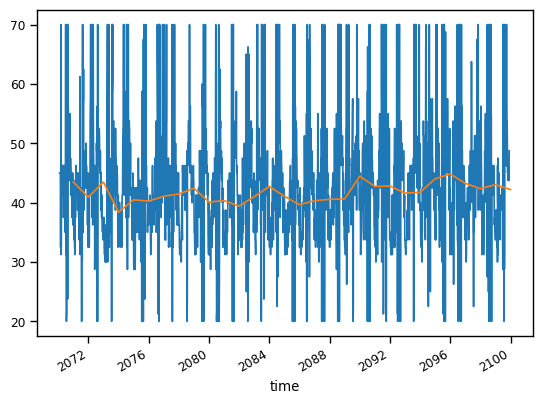

In [55]:
all_df_npac_future_dataset['Woollings et al. 2010']['HadGEM3-GC31-LL_r1i1p1f3'].dropna().plot()
all_df_npac_future_dataset['Bracegirdle et al. 2018']['HadGEM3-GC31-LL_r1i1p1f3'].dropna().plot()

In [56]:
len(all_df_npac_future_dataset['Woollings et al. 2010'].columns), len(all_df_npac_future_dataset['Barnes & Polvani 2015'].columns)

(58, 58)

#### view ensembles

In [84]:
collections.Counter([row.split('_r')[0] for row in all_df_npac_future_dataset['Woollings et al. 2010'].columns])

Counter({'CanESM5': 20,
         'UKESM1-0-LL': 7,
         'HadGEM3-GC31-LL': 4,
         'HadGEM3-GC31-MM': 4,
         'MIROC6': 3,
         'CESM2-WACCM': 3,
         'MPI-ESM1-2-LR': 3,
         'ACCESS-ESM1-5': 2,
         'CMCC-ESM2': 1,
         'NorESM2-LM': 1,
         'NorESM2-MM': 1,
         'MRI-ESM2-0': 1,
         'NESM3': 1,
         'MPI-ESM1-2-HR': 1,
         'ACCESS-CM2': 1,
         'TaiESM1': 1,
         'BCC-CSM2-MR': 1,
         'CMCC-CM2-SR5': 1,
         'FGOALS-g3': 1,
         'AWI-CM-1-1-MR': 1})

In [67]:
# sorted(all_df_npac_future_dataset['Woollings et al. 2010'].columns, key=lambda row: row.split('_')[0])

# Load CMIP6 Historical

In [72]:
HIST_START_DATE = "1950-01-01"
HIST_END_DATE = "2015-12-31"
PERIOD_NUMBER_OF_DAYS = (pd.to_datetime(HIST_END_DATE) - pd.to_datetime(HIST_START_DATE)).days
MISSING_NUM_DAYS_THRESHOLD = 0.05 ## only allow for up to 5% less duration in data 

In [73]:
CMIP6_Historical_dir = "/home/thomaskeel/Documents/PhD/JASMIN experiments/CMIP6_Historical_NPAC runs/ua_day*"

In [74]:
metric_names = ["Woollings et al. 2010", "Barnes & Polvani 2013", "Barnes & Polvani 2015", \
                "Barnes & Simpson 2017", "Grise & Polvani 2017", "Bracegirdle et al. 2018", \
                "Ceppi et al. 2018", "Kerr et al. 2020"]
COLS_TO_REMOVE = ["10_day_average", "plev"]

region = "North Pacific"

In [75]:
print(region, len(glob.glob(CMIP6_Historical_dir + region + "*")))

North Pacific 814


In [76]:
%%time
## takes ~27 seconds on Intel i7-10750 

time_ranges = []
failed_data_paths = []
data_paths_not_enough_days = []
date_format="\d{2}:\d{2}:\d{2}"
for file_path in glob.glob(CMIP6_Historical_dir):
    try:
        current = pd.read_csv(file_path, header=0)
    except Exception as e:
        print(e)
        print(file_path)
        continue
    for col in COLS_TO_REMOVE:
        try:
            current.drop(col, inplace=True, axis=1)
        except:
            pass
    try:
        current['time'] = current['time'].apply(lambda x: re.sub(date_format, "", x).strip())
    except Exception as e:
#         print(e)
        failed_data_paths.append(file_path)
        continue
    first_time = current['time'].min()
    last_time = current['time'].max()
    current_data_period_in_days = (pd.to_datetime(last_time) - pd.to_datetime(first_time)).days
    ## check there is enough days
    if (PERIOD_NUMBER_OF_DAYS * MISSING_NUM_DAYS_THRESHOLD) < current_data_period_in_days:
        time_ranges.append(str(first_time)+'to'+str(last_time))
    else:
        data_paths_not_enough_days.append(file_path)

CPU times: user 27.3 s, sys: 422 ms, total: 27.7 s
Wall time: 27.9 s


In [77]:
collections.Counter(time_ranges)

Counter({'1950-01-01to2014-12-31': 405,
         '1950-01-01to2014-12-30': 162,
         '1950-01-01to2015-01-01': 72,
         '1950-01-01to2014-12-27': 32,
         '1950-01-01to2014-12-21': 27,
         '1950-01-01to2015-12-31': 6,
         '1950-01-02to2014-12-31': 6,
         '1950-01-02to2014-12-28': 1,
         '1950-01-01to2015-12-22': 1})

In [79]:
len(data_paths_not_enough_days)

0

In [80]:
## check all failures are bracegirdle (because this is an annual metric)
all(['Bracegirdle et al. 2018' in fn for fn in failed_data_paths]), len(failed_data_paths)

(True, 102)

In [101]:
%%time
## takes ~35 seconds on Intel i7-10750 
all_df_npac_hist_dataset = {}
for metric in metric_names:
    if metric == "Bracegirdle et al. 2018":
        all_df_npac_hist_dataset[metric] = make_combined_df_from_data_paths_for_bracegirdle(glob.glob(CMIP6_Historical_dir + metric + "*" + "North Pacific" + "*"),
                                                                                           ignored_data_paths=[])
        continue
    all_df_npac_hist_dataset[metric] = make_combined_df_from_data_paths(glob.glob(CMIP6_Historical_dir + metric + "*" + "North Pacific" + "*"),
                                                                       ignored_data_paths=data_paths_not_enough_days)


CPU times: user 37.2 s, sys: 128 ms, total: 37.3 s
Wall time: 37.3 s


In [102]:
all_df_npac_hist_dataset['Woollings et al. 2010'].columns

Index(['ACCESS-CM2_r1i1p1f1', 'IPSL-CM6A-LR_r2i1p1f1', 'CNRM-CM6-1_r8i1p1f2',
       'CESM2_r5i1p1f1', 'CNRM-CM6-1_r4i1p1f2', 'BCC-CSM2-MR_r3i1p1f1',
       'HadGEM3-GC31-MM_r1i1p1f3', 'IPSL-CM6A-LR_r9i1p1f1',
       'ACCESS-ESM1-5_r1i1p1f1', 'UKESM1-0-LL_r1i1p1f2',
       ...
       'BCC-ESM1_r3i1p1f1', 'CanESM5_r1i1p1f1', 'BCC-CSM2-MR_r2i1p1f1',
       'GFDL-CM4_r1i1p1f1', 'CanESM5_r1i1p2f1', 'UKESM1-0-LL_r17i1p1f2',
       'IPSL-CM6A-LR_r5i1p1f1', 'INM-CM4-8_r1i1p1f1', 'IPSL-CM6A-LR_r6i1p1f1',
       'UKESM1-0-LL_r15i1p1f2'],
      dtype='object', length=101)

In [ ]:
set(all_df_npac_hist_dataset['Barnes & Simpson 2017'].columns).difference(set(all_df_npac_hist_dataset['Woollings et al. 2010'].columns))

In [103]:
%%time
## takes ~600 milliseconds on Intel i7-10750 
## rerun above 2 cell if you have a problem with Bracegirlde et al. 2018
START_YEAR = HIST_START_DATE[:4] # "1950"
END_YEAR = HIST_END_DATE[:4] # "2015"
FREQ = 'd'
for metric in metric_names:
    # print(metric)
    if metric == "Bracegirdle et al. 2018":
        all_df_npac_hist_dataset[metric].index = pd.date_range(start="1950", freq="y", periods=len(all_df_npac_hist_dataset[metric])) # NOTE: START YEAR HARD CODED
        all_df_npac_hist_dataset[metric].index = all_df_npac_hist_dataset[metric].index.rename('time')
    all_df_npac_hist_dataset[metric].index = pd.to_datetime(all_df_npac_hist_dataset[metric].index, errors='coerce')
    all_df_npac_hist_dataset[metric] = all_df_npac_hist_dataset[metric].groupby(pd.Grouper(freq=FREQ)).mean()
    all_df_npac_hist_dataset[metric] = all_df_npac_hist_dataset[metric][START_YEAR: END_YEAR]
    if 'IITM-ESM_r1i1p1f1' in all_df_npac_hist_dataset[metric].columns:
        all_df_npac_hist_dataset[metric] = all_df_npac_hist_dataset[metric].drop('IITM-ESM_r1i1p1f1', axis=1)
        print('removed IITM-ESM_r1i1p1f1')

removed IITM-ESM_r1i1p1f1
removed IITM-ESM_r1i1p1f1
removed IITM-ESM_r1i1p1f1
removed IITM-ESM_r1i1p1f1
removed IITM-ESM_r1i1p1f1
removed IITM-ESM_r1i1p1f1
CPU times: user 390 ms, sys: 168 ms, total: 558 ms
Wall time: 557 ms


In [105]:
len(all_df_npac_hist_dataset['Woollings et al. 2010'].columns), len(all_df_npac_hist_dataset['Barnes & Polvani 2015'].columns)

(101, 101)

In [106]:
collections.Counter([row.split('_r')[0] for row in all_df_npac_hist_dataset['Woollings et al. 2010'].columns])

Counter({'UKESM1-0-LL': 17,
         'CNRM-CM6-1': 10,
         'IPSL-CM6A-LR': 9,
         'CESM2': 8,
         'CNRM-ESM2-1': 5,
         'HadGEM3-GC31-LL': 5,
         'HadGEM3-GC31-MM': 4,
         'CESM2-WACCM': 3,
         'BCC-ESM1': 3,
         'BCC-CSM2-MR': 2,
         'GISS-E2-1-G': 2,
         'CanESM5': 2,
         'ACCESS-CM2': 1,
         'ACCESS-ESM1-5': 1,
         'EC-Earth3-AerChem': 1,
         'TaiESM1': 1,
         'MIROC-ES2L': 1,
         'FGOALS-g3': 1,
         'MPI-ESM-1-2-HAM': 1,
         'KACE-1-0-G': 1,
         'MRI-ESM2-0': 1,
         'CMCC-ESM2': 1,
         'MPI-ESM1-2-HR': 1,
         'INM-CM5-0': 1,
         'NorESM2-LM': 1,
         'CMCC-CM2-SR5': 1,
         'CMCC-CM2-HR4': 1,
         'MPI-ESM1-2-LR': 1,
         'EC-Earth3': 1,
         'IPSL-CM5A2-INCA': 1,
         'MIROC6': 1,
         'CNRM-CM6-1-HR': 1,
         'CESM2-FV2': 1,
         'AWI-ESM-1-1-LR': 1,
         'NorESM2-MM': 1,
         'FGOALS-f3-L': 1,
         'IPSL-CM6A-LR-INCA':

## Load Reanalysis

In [128]:
REAN_START_DATE = "1984-01-01"
REAN_END_DATE = "2022-12-31"
REAN_START_YEAR = REAN_START_DATE[:4]
REAN_END_YEAR = REAN_END_DATE[:4]

In [142]:
era_npac_day_dict = {}

era_npac_day_dict['Woollings2010_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_ERA5_daily_outputs/Woollings et al. 2010 North Pacific.csv', index_col='time')[REAN_START_YEAR: REAN_END_YEAR]
era_npac_day_dict['BarnesPolvani2013_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_ERA5_daily_outputs/Barnes & Polvani 2013 North Pacific.csv', index_col='time')[REAN_START_YEAR: REAN_END_YEAR]
era_npac_day_dict['BarnesPolvani2015_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_ERA5_daily_outputs/Barnes & Polvani 2015 North Pacific.csv', index_col='time')[REAN_START_YEAR: REAN_END_YEAR]
era_npac_day_dict['BarnesSimpson2017_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_ERA5_daily_outputs/Barnes & Simpson 2017 North Pacific.csv', index_col='time')[REAN_START_YEAR: REAN_END_YEAR]
era_npac_day_dict['GrisePolvani2017_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_ERA5_daily_outputs/Grise & Polvani 2017 North Pacific.csv', index_col='time')[REAN_START_YEAR: REAN_END_YEAR]
era_npac_day_dict['Bracegirdle2018_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_ERA5_daily_outputs/Bracegirdle et al. 2018 North Pacific.csv', index_col='year')[24:]##HARDCODED as starts at 1959
era_npac_day_dict['Ceppi2018_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_ERA5_daily_outputs/Ceppi et al. 2018 North Pacific.csv', index_col='time')[REAN_START_YEAR: REAN_END_YEAR]
era_npac_day_dict['Kerr2020_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_ERA5_daily_outputs/Kerr et al. 2020 North Pacific.csv', index_col='time')[REAN_START_YEAR: REAN_END_YEAR]


In [143]:
jra55_npac_day_dict = {}

jra55_npac_day_dict['Woollings2010_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_JRA55_daily_outputs/Woollings et al. 2010 North Pacific.csv', index_col='time')[REAN_START_YEAR: REAN_END_YEAR]
jra55_npac_day_dict['BarnesPolvani2013_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_JRA55_daily_outputs/Barnes & Polvani 2013 North Pacific.csv', index_col='time')[REAN_START_YEAR: REAN_END_YEAR]
jra55_npac_day_dict['BarnesPolvani2015_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_JRA55_daily_outputs/Barnes & Polvani 2015 North Pacific.csv', index_col='time')[REAN_START_YEAR: REAN_END_YEAR]
jra55_npac_day_dict['BarnesSimpson2017_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_JRA55_daily_outputs/Barnes & Simpson 2017 North Pacific.csv', index_col='time')[REAN_START_YEAR: REAN_END_YEAR]
jra55_npac_day_dict['GrisePolvani2017_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_JRA55_daily_outputs/Grise & Polvani 2017 North Pacific.csv', index_col='time')[REAN_START_YEAR: REAN_END_YEAR]
jra55_npac_day_dict['Bracegirdle2018_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_JRA55_daily_outputs/Bracegirdle et al. 2018 North Pacific.csv', index_col='year')
jra55_npac_day_dict['Ceppi2018_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_JRA55_daily_outputs/Ceppi et al. 2018 North Pacific.csv', index_col='time')[REAN_START_YEAR: REAN_END_YEAR]
jra55_npac_day_dict['Kerr2020_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_JRA55_daily_outputs/Kerr et al. 2020 North Pacific.csv', index_col='time')[REAN_START_YEAR: REAN_END_YEAR]


In [144]:
merra2_npac_day_dict = {}

merra2_npac_day_dict['Woollings2010_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_MERRA2_daily_outputs/Woollings et al. 2010 North Pacific.csv', index_col='time')[REAN_START_YEAR: REAN_END_YEAR]
merra2_npac_day_dict['BarnesPolvani2013_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_MERRA2_daily_outputs/Barnes & Polvani 2013 North Pacific.csv', index_col='time')[REAN_START_YEAR: REAN_END_YEAR]
merra2_npac_day_dict['BarnesPolvani2015_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_MERRA2_daily_outputs/Barnes & Polvani 2015 North Pacific.csv', index_col='time')[REAN_START_YEAR: REAN_END_YEAR]
merra2_npac_day_dict['BarnesSimpson2017_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_MERRA2_daily_outputs/Barnes & Simpson 2017 North Pacific.csv', index_col='time')[REAN_START_YEAR: REAN_END_YEAR]
merra2_npac_day_dict['GrisePolvani2017_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_MERRA2_daily_outputs/Grise & Polvani 2017 North Pacific.csv', index_col='time')[REAN_START_YEAR: REAN_END_YEAR]
merra2_npac_day_dict['Bracegirdle2018_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_MERRA2_daily_outputs/Bracegirdle et al. 2018 North Pacific.csv', index_col='year')[3:]##HARDCODED as starts at 1980
merra2_npac_day_dict['Ceppi2018_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_MERRA2_daily_outputs/Ceppi et al. 2018 North Pacific.csv', index_col='time')[REAN_START_YEAR: REAN_END_YEAR]
merra2_npac_day_dict['Kerr2020_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_MERRA2_daily_outputs/Kerr et al. 2020 North Pacific.csv', index_col='time')[REAN_START_YEAR: REAN_END_YEAR]


In [145]:
ncepdoe2_npac_day_dict = {}

ncepdoe2_npac_day_dict['Woollings2010_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_NCEPDOE2_daily_outputs/Woollings et al. 2010 North Pacific.csv', index_col='time')[REAN_START_YEAR: REAN_END_YEAR]
ncepdoe2_npac_day_dict['BarnesPolvani2013_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_NCEPDOE2_daily_outputs/Barnes & Polvani 2013 North Pacific.csv', index_col='time')[REAN_START_YEAR: REAN_END_YEAR]
ncepdoe2_npac_day_dict['BarnesPolvani2015_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_NCEPDOE2_daily_outputs/Barnes & Polvani 2015 North Pacific.csv', index_col='time')[REAN_START_YEAR: REAN_END_YEAR]
ncepdoe2_npac_day_dict['BarnesSimpson2017_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_NCEPDOE2_daily_outputs/Barnes & Simpson 2017 North Pacific.csv', index_col='time')[REAN_START_YEAR: REAN_END_YEAR]
ncepdoe2_npac_day_dict['GrisePolvani2017_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_NCEPDOE2_daily_outputs/Grise & Polvani 2017 North Pacific.csv', index_col='time')[REAN_START_YEAR: REAN_END_YEAR]
ncepdoe2_npac_day_dict['Bracegirdle2018_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_NCEPDOE2_daily_outputs/Bracegirdle et al. 2018 North Pacific.csv', index_col='year')[3:]##HARDCODED as starts at 1980
ncepdoe2_npac_day_dict['Ceppi2018_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_NCEPDOE2_daily_outputs/Ceppi et al. 2018 North Pacific.csv', index_col='time')[REAN_START_YEAR: REAN_END_YEAR]
ncepdoe2_npac_day_dict['Kerr2020_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_NCEPDOE2_daily_outputs/Kerr et al. 2020 North Pacific.csv', index_col='time')[REAN_START_YEAR: REAN_END_YEAR]


In [147]:
## Check length of Bracegirlde data
len(era_npac_day_dict['Bracegirdle2018_NorthPacific']), len(jra55_npac_day_dict['Bracegirdle2018_NorthPacific']), len(merra2_npac_day_dict['Bracegirdle2018_NorthPacific']), len(ncepdoe2_npac_day_dict['Bracegirdle2018_NorthPacific'])

(40, 40, 40, 40)

# Calculate Jet latitude mean and trends...

In [163]:
### required functions for calculating gradient/trend and formatting data
def get_linear_reg_slope(data, col_name):
    lin_reg_data = prepare_data_for_linear_reg(data, col_name)
    return linear_reg_slope(lin_reg_data)


def prepare_data_for_linear_reg(data, col_name):
    values = data[col_name].values.astype(float)
    ordinal_dates = get_ordinal_dates(data)
    lin_reg_data = pd.DataFrame([values, ordinal_dates]).T
    lin_reg_data = lin_reg_data.dropna()
    return lin_reg_data


def get_ordinal_dates(data, index_col_name='time'):
    return pd.to_datetime(data.reset_index()[index_col_name]).apply(lambda date: date.toordinal())


def linear_reg_slope(data):
    """
        data[0] should be values, data[1] should be ordinal dates
    """
    slope, intercept = np.polyfit(data[1], data[0], 1)
    lr1d = np.poly1d([slope, intercept])(data[1])
    return pd.DataFrame(lr1d, index=data[1].apply(lambda row: pd.to_datetime(datetime.date.fromordinal(int(row)))), columns=['reg_line'])

def get_year_gradient_of_trend(data, jet_lat_name='jet_lat', proportion_threshold_for_missing_data=4):
    """
        TODO: fix ValueError: You must specify a period or x must be a pandas object with a PeriodIndex or a DatetimeIndex with a freq not set to None
    """
    try:
        cdata = data.dropna()
        lin_reg_line = get_linear_reg_slope(data, jet_lat_name)
        year_gradient = (lin_reg_line['reg_line'][-1] - lin_reg_line['reg_line'][0]) / (lin_reg_line.index.year[-1]  - lin_reg_line.index.year[0])
        return year_gradient
    except ValueError as ve:
        print(ve)
        pass
    try:
        assert float(data.isnull().sum(axis=0)) < (len(data)/proportion_threshold_for_missing_data)
        data = data.fillna(data.mean())
        lin_reg_line = get_linear_reg_slope(data, jet_lat_name)
        year_gradient = (lin_reg_line['reg_line'][-1] - lin_reg_line['reg_line'][0]) / (lin_reg_line.index.year[-1]  - lin_reg_line.index.year[0])
        return year_gradient
    except AssertionError as ae:
        print(f"{data.name}failed. {int(data.isnull().sum(axis=0))} out of {len(data)} data points missing")
        return np.nan
    
def format_dict_to_dataframe(jet_lat_dict, unique_col_name):
    jet_lat_df = pd.DataFrame(jet_lat_dict)
    jet_lat_df = jet_lat_df.stack().reset_index()
    jet_lat_df.columns = ["Metric", "Dataset", unique_col_name]
    ## rename metric name to formatted version
    jet_lat_df['Metric'] = jet_lat_df.Metric.apply(lambda row: METRIC_LABEL_RENAMER[row])
    ## include decade trend 
    if 'trend' in unique_col_name.lower():
        jet_lat_df[unique_col_name+'_decade'] = jet_lat_df[unique_col_name]*10
    return jet_lat_df

## ... for reanalysis

In [150]:
%%time
## takes ~28 seconds on Intel i7-10750 
reanalysis_data = [era_npac_day_dict, jra55_npac_day_dict, merra2_npac_day_dict, ncepdoe2_npac_day_dict]
reanalysis_names = ["ERA-5", "JRA-55", "MERRA-2", "NCEP/DOE II"]
djf_jet_lat_mean_dict = {}
mam_jet_lat_mean_dict = {}
jja_jet_lat_mean_dict = {}
son_jet_lat_mean_dict = {}
djf_jet_lat_trend_dict = {}
mam_jet_lat_trend_dict = {}
jja_jet_lat_trend_dict = {}
son_jet_lat_trend_dict = {}
for ind, reanalysis_set in enumerate(reanalysis_data):
    reanalysis_name = reanalysis_names[ind]
    djf_jet_lat_mean_dict[reanalysis_name] = {}
    mam_jet_lat_mean_dict[reanalysis_name] = {}
    jja_jet_lat_mean_dict[reanalysis_name] = {}
    son_jet_lat_mean_dict[reanalysis_name] = {}
    djf_jet_lat_trend_dict[reanalysis_name] = {}
    mam_jet_lat_trend_dict[reanalysis_name] = {}
    jja_jet_lat_trend_dict[reanalysis_name] = {}
    son_jet_lat_trend_dict[reanalysis_name] = {}
    print(reanalysis_name)
    for metric in METRIC_DATA_NAMES:
        if metric == "Bracegirdle2018_NorthPacific":
            ## ignore because only calculated by annual scale
            continue
        else:
            reanalysis_set[metric].index = pd.to_datetime(reanalysis_set[metric].index)
            djf_jet_lat_mean_dict[reanalysis_name][metric] = float(reanalysis_set[metric][reanalysis_set[metric].index.month.isin([12, 1, 2])]['jet_lat'].mean())
            mam_jet_lat_mean_dict[reanalysis_name][metric] = float(reanalysis_set[metric][reanalysis_set[metric].index.month.isin([3, 4, 5])]['jet_lat'].mean())
            jja_jet_lat_mean_dict[reanalysis_name][metric] = float(reanalysis_set[metric][reanalysis_set[metric].index.month.isin([6, 7, 8])]['jet_lat'].mean())
            son_jet_lat_mean_dict[reanalysis_name][metric] = float(reanalysis_set[metric][reanalysis_set[metric].index.month.isin([9, 10, 11])]['jet_lat'].mean())
   
            djf_jet_lat_trend_dict[reanalysis_name][metric] = get_year_gradient_of_trend(reanalysis_set[metric][reanalysis_set[metric].index.month.isin([12, 1, 2])])
            mam_jet_lat_trend_dict[reanalysis_name][metric] = get_year_gradient_of_trend(reanalysis_set[metric][reanalysis_set[metric].index.month.isin([3, 4, 5])])
            jja_jet_lat_trend_dict[reanalysis_name][metric] = get_year_gradient_of_trend(reanalysis_set[metric][reanalysis_set[metric].index.month.isin([6, 7, 8])])
            son_jet_lat_trend_dict[reanalysis_name][metric] = get_year_gradient_of_trend(reanalysis_set[metric][reanalysis_set[metric].index.month.isin([9, 10, 11])])

ERA-5
JRA-55
MERRA-2
NCEP/DOE II
CPU times: user 27.6 s, sys: 7.96 ms, total: 27.6 s
Wall time: 27.6 s


In [159]:
djf_jet_lat_mean_df = format_dict_to_dataframe(djf_jet_lat_mean_dict, "DJF Mean")
djf_jet_lat_trend_df = format_dict_to_dataframe(djf_jet_lat_trend_dict, "DJF Trend")

mam_jet_lat_mean_df = format_dict_to_dataframe(mam_jet_lat_mean_dict, "MAM Mean")
mam_jet_lat_trend_df = format_dict_to_dataframe(mam_jet_lat_trend_dict, "MAM Trend")

jja_jet_lat_mean_df = format_dict_to_dataframe(jja_jet_lat_mean_dict, "JJA Mean")
jja_jet_lat_trend_df = format_dict_to_dataframe(jja_jet_lat_trend_dict, "JJA Trend")

son_jet_lat_mean_df = format_dict_to_dataframe(son_jet_lat_mean_dict, "SON Mean")
son_jet_lat_trend_df = format_dict_to_dataframe(son_jet_lat_trend_dict, "SON Trend")

In [164]:
## merge all
allseasons_jet_lat_mean_df = djf_jet_lat_mean_df.merge(mam_jet_lat_mean_df)
allseasons_jet_lat_mean_df = allseasons_jet_lat_mean_df.merge(jja_jet_lat_mean_df)
allseasons_jet_lat_mean_df = allseasons_jet_lat_mean_df.merge(son_jet_lat_mean_df)

allseasons_jet_lat_trend_df = djf_jet_lat_trend_df.merge(mam_jet_lat_trend_df)
allseasons_jet_lat_trend_df = allseasons_jet_lat_trend_df.merge(jja_jet_lat_trend_df)
allseasons_jet_lat_trend_df = allseasons_jet_lat_trend_df.merge(son_jet_lat_trend_df)

all_seasons_rean_jet_lat_mean_and_trend_df = allseasons_jet_lat_mean_df.merge(allseasons_jet_lat_trend_df)

In [165]:
all_seasons_rean_jet_lat_mean_and_trend_df.head()

,Metric,Dataset,DJF Mean,MAM Mean,JJA Mean,SON Mean,DJF Trend,DJF Trend_decade,MAM Trend,MAM Trend_decade,JJA Trend,JJA Trend_decade,SON Trend,SON Trend_decade
0,Woollings et al. 2010,ERA-5,38.748688,41.339531,46.655034,45.835165,0.053320,0.533202,0.044530,0.445303,0.035942,0.359416,-0.033343,-0.333435
1,Woollings et al. 2010,JRA-55,38.767652,41.387657,46.984411,45.876952,0.039297,0.392969,0.040919,0.409191,0.057011,0.570109,-0.011208,-0.112083
2,Woollings et al. 2010,MERRA-2,38.708455,41.351974,46.189630,45.786051,0.035205,0.352047,0.018390,0.183904,0.029045,0.290452,-0.016935,-0.169352
3,Woollings et al. 2010,NCEP/DOE II,38.586735,41.132008,46.540332,45.898641,0.043941,0.439411,0.023232,0.232317,0.008886,0.088858,-0.029689,-0.296886
4,Barnes & Polvani 2013,ERA-5,38.877472,41.427780,46.456645,45.876816,0.055185,0.551847,0.044182,0.441824,0.028941,0.289408,-0.034815,-0.348148


## .. for CMIP6 Historical

In [201]:
%%time
## takes ~20 minutes on Intel i7-10750 

hist_djf_jet_lat_mean_dict = {}
hist_mam_jet_lat_mean_dict = {}
hist_jja_jet_lat_mean_dict = {}
hist_son_jet_lat_mean_dict = {}

hist_djf_jet_lat_trend_dict = {}
hist_mam_jet_lat_trend_dict = {}
hist_jja_jet_lat_trend_dict = {}
hist_son_jet_lat_trend_dict = {}

for metric in metric_names:
    print(metric)
    if metric == "Bracegirdle et al. 2018":
        ## ignore because only calculated by annual scale
        continue
    hist_djf_jet_lat_mean_dict[metric] = all_df_npac_hist_dataset[metric][all_df_npac_hist_dataset[metric].index.month.isin([12, 1, 2])].mean()
    hist_mam_jet_lat_mean_dict[metric] = all_df_npac_hist_dataset[metric][all_df_npac_hist_dataset[metric].index.month.isin([3, 4, 5])].mean()
    hist_jja_jet_lat_mean_dict[metric] = all_df_npac_hist_dataset[metric][all_df_npac_hist_dataset[metric].index.month.isin([6, 7, 8])].mean()
    hist_son_jet_lat_mean_dict[metric] = all_df_npac_hist_dataset[metric][all_df_npac_hist_dataset[metric].index.month.isin([9, 10, 11])].mean()
    
    hist_djf_jet_lat_trend_dict[metric] = all_df_npac_hist_dataset[metric][all_df_npac_hist_dataset[metric].index.month.isin([12, 1, 2])].apply(lambda col: get_year_gradient_of_trend(pd.DataFrame(col), col.name), axis=0)
    hist_mam_jet_lat_trend_dict[metric] = all_df_npac_hist_dataset[metric][all_df_npac_hist_dataset[metric].index.month.isin([3, 4, 5])].apply(lambda col: get_year_gradient_of_trend(pd.DataFrame(col), col.name), axis=0)
    hist_jja_jet_lat_trend_dict[metric] = all_df_npac_hist_dataset[metric][all_df_npac_hist_dataset[metric].index.month.isin([6, 7, 8])].apply(lambda col: get_year_gradient_of_trend(pd.DataFrame(col), col.name), axis=0)
    hist_son_jet_lat_trend_dict[metric] = all_df_npac_hist_dataset[metric][all_df_npac_hist_dataset[metric].index.month.isin([9, 10, 11])].apply(lambda col: get_year_gradient_of_trend(pd.DataFrame(col), col.name), axis=0)

Woollings et al. 2010
Barnes & Polvani 2013
Barnes & Polvani 2015
Barnes & Simpson 2017
Grise & Polvani 2017
Bracegirdle et al. 2018
Ceppi et al. 2018
Kerr et al. 2020
CPU times: user 19min 36s, sys: 95.7 ms, total: 19min 36s
Wall time: 19min 36s


In [204]:
hist_djf_jet_lat_trend_dict['Woollings et al. 2010']

ACCESS-CM2_r1i1p1f1      0.001884
IPSL-CM6A-LR_r2i1p1f1   -0.017593
CNRM-CM6-1_r8i1p1f2     -0.008218
CESM2_r5i1p1f1           0.011168
CNRM-CM6-1_r4i1p1f2     -0.018880
                           ...   
UKESM1-0-LL_r17i1p1f2   -0.007376
IPSL-CM6A-LR_r5i1p1f1   -0.033776
INM-CM4-8_r1i1p1f1      -0.010560
IPSL-CM6A-LR_r6i1p1f1    0.002443
UKESM1-0-LL_r15i1p1f2    0.008406
Length: 101, dtype: float64

In [205]:
hist_djf_jet_lat_mean_df = pd.concat(hist_djf_jet_lat_mean_dict, axis=1)
hist_mam_jet_lat_mean_df = pd.concat(hist_mam_jet_lat_mean_dict, axis=1)
hist_jja_jet_lat_mean_df = pd.concat(hist_jja_jet_lat_mean_dict, axis=1)
hist_son_jet_lat_mean_df = pd.concat(hist_son_jet_lat_mean_dict, axis=1)

hist_djf_jet_lat_trend_df = pd.concat(hist_djf_jet_lat_trend_dict, axis=1)
hist_mam_jet_lat_trend_df = pd.concat(hist_mam_jet_lat_trend_dict, axis=1)
hist_jja_jet_lat_trend_df = pd.concat(hist_jja_jet_lat_trend_dict, axis=1)
hist_son_jet_lat_trend_df = pd.concat(hist_son_jet_lat_trend_dict, axis=1)

In [206]:
hist_djf_jet_lat_trend_df.head()

,Woollings et al. 2010,Barnes & Polvani 2013,Barnes & Polvani 2015,Barnes & Simpson 2017,Grise & Polvani 2017,Ceppi et al. 2018,Kerr et al. 2020
ACCESS-CM2_r1i1p1f1,0.001884,0.000491,0.028064,0.010110,-0.001994,-0.000070,-0.000612
IPSL-CM6A-LR_r2i1p1f1,-0.017593,-0.014516,-0.009559,-0.007515,-0.029412,-0.014538,-0.015961
CNRM-CM6-1_r8i1p1f2,-0.008218,-0.007506,-0.020124,-0.000811,-0.009105,-0.004572,-0.015341
CESM2_r5i1p1f1,0.011168,0.012730,-0.008385,0.011809,0.011034,0.010223,0.010356
CNRM-CM6-1_r4i1p1f2,-0.018880,-0.020740,-0.003606,-0.012392,-0.025479,-0.018200,-0.011524


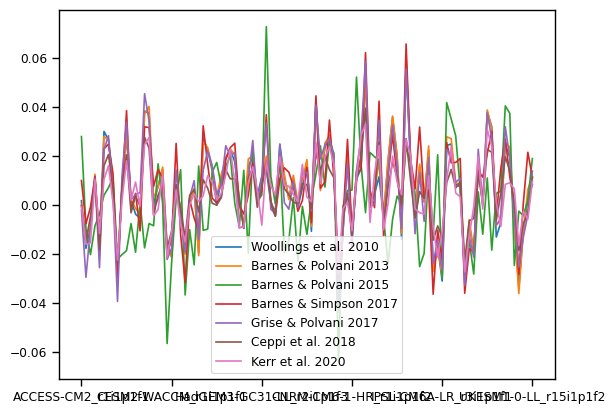

In [211]:
hist_djf_jet_lat_trend_df.plot();

## .. for CMIP6 SSP5-8.5

In [212]:
%%time
## takes ~5.5 minutes on Intel i7-10750 

ssp585_djf_jet_lat_mean_dict = {}
ssp585_mam_jet_lat_mean_dict = {}
ssp585_jja_jet_lat_mean_dict = {}
ssp585_son_jet_lat_mean_dict = {}

ssp585_djf_jet_lat_trend_dict = {}
ssp585_mam_jet_lat_trend_dict = {}
ssp585_jja_jet_lat_trend_dict = {}
ssp585_son_jet_lat_trend_dict = {}

for metric in metric_names:
    print(metric)
    if metric == "Bracegirdle et al. 2018":
        ## ignore because only calculated by annual scale
        continue
    ssp585_djf_jet_lat_mean_dict[metric] = all_df_npac_future_dataset[metric][all_df_npac_future_dataset[metric].index.month.isin([12, 1, 2])].mean()
    ssp585_mam_jet_lat_mean_dict[metric] = all_df_npac_future_dataset[metric][all_df_npac_future_dataset[metric].index.month.isin([3, 4, 5])].mean()
    ssp585_jja_jet_lat_mean_dict[metric] = all_df_npac_future_dataset[metric][all_df_npac_future_dataset[metric].index.month.isin([6, 7, 8])].mean()
    ssp585_son_jet_lat_mean_dict[metric] = all_df_npac_future_dataset[metric][all_df_npac_future_dataset[metric].index.month.isin([9, 10, 11])].mean()
    
    ssp585_djf_jet_lat_trend_dict[metric] = all_df_npac_future_dataset[metric][all_df_npac_future_dataset[metric].index.month.isin([12, 1, 2])].apply(lambda col: get_year_gradient_of_trend(pd.DataFrame(col), col.name), axis=0)
    ssp585_mam_jet_lat_trend_dict[metric] = all_df_npac_future_dataset[metric][all_df_npac_future_dataset[metric].index.month.isin([3, 4, 5])].apply(lambda col: get_year_gradient_of_trend(pd.DataFrame(col), col.name), axis=0)
    ssp585_jja_jet_lat_trend_dict[metric] = all_df_npac_future_dataset[metric][all_df_npac_future_dataset[metric].index.month.isin([6, 7, 8])].apply(lambda col: get_year_gradient_of_trend(pd.DataFrame(col), col.name), axis=0)
    ssp585_son_jet_lat_trend_dict[metric] = all_df_npac_future_dataset[metric][all_df_npac_future_dataset[metric].index.month.isin([9, 10, 11])].apply(lambda col: get_year_gradient_of_trend(pd.DataFrame(col), col.name), axis=0)

Woollings et al. 2010
Barnes & Polvani 2013
Barnes & Polvani 2015
Barnes & Simpson 2017
Grise & Polvani 2017
Bracegirdle et al. 2018
Ceppi et al. 2018
Kerr et al. 2020
CPU times: user 5min 15s, sys: 24 ms, total: 5min 15s
Wall time: 5min 15s


In [213]:
ssp585_djf_jet_lat_mean_df = pd.concat(ssp585_djf_jet_lat_mean_dict, axis=1)
ssp585_mam_jet_lat_mean_df = pd.concat(ssp585_mam_jet_lat_mean_dict, axis=1)
ssp585_jja_jet_lat_mean_df = pd.concat(ssp585_jja_jet_lat_mean_dict, axis=1)
ssp585_son_jet_lat_mean_df = pd.concat(ssp585_son_jet_lat_mean_dict, axis=1)

ssp585_djf_jet_lat_trend_df = pd.concat(ssp585_djf_jet_lat_trend_dict, axis=1)
ssp585_mam_jet_lat_trend_df = pd.concat(ssp585_mam_jet_lat_trend_dict, axis=1)
ssp585_jja_jet_lat_trend_df = pd.concat(ssp585_jja_jet_lat_trend_dict, axis=1)
ssp585_son_jet_lat_trend_df = pd.concat(ssp585_son_jet_lat_trend_dict, axis=1)

In [214]:
ssp585_djf_jet_lat_trend_df.head()

,Woollings et al. 2010,Barnes & Polvani 2013,Barnes & Polvani 2015,Barnes & Simpson 2017,Grise & Polvani 2017,Ceppi et al. 2018,Kerr et al. 2020
CanESM5_r3i1p1f1,-0.012441,-0.011671,0.055207,-0.022139,0.006236,-0.003113,0.016096
CMCC-ESM2_r1i1p1f1,0.093766,0.104211,-0.029850,0.102526,0.096225,0.055372,0.078099
CanESM5_r10i1p2f1,0.059445,0.076840,0.091350,0.061325,0.038451,0.051827,0.035471
UKESM1-0-LL_r14i1p1f2,-0.024664,-0.018691,0.096534,-0.043708,-0.017527,-0.001240,-0.006313
CanESM5_r5i1p2f1,0.101297,0.098444,0.122564,0.070370,0.110759,0.079301,0.071234


<Axes: >

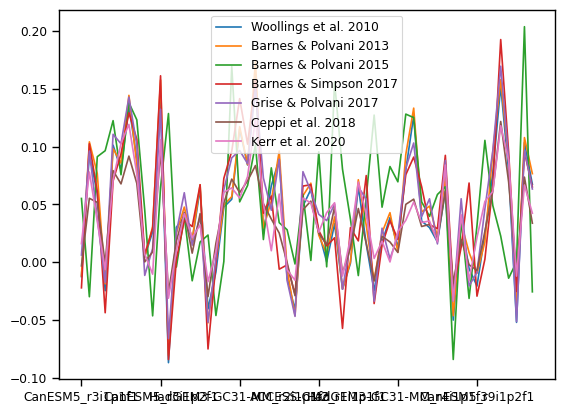

In [215]:
ssp585_djf_jet_lat_trend_df.plot()

# Make Figure 4